In [118]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM
import pandas as pd
import torch
from glob import glob

from py.Dataset import Dataset
from py.FileUtils import load
from py.PlotUtils import plot_roc_curve, get_percentiles
from py.PyTorchData import get_log, create_dataloader, model_output_to_image
from py.Labels import LABELS
from py.Autoencoder3 import Autoencoder
from py.ImageUtils import display_images

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory
SESSION = "marten_01"
TRAIN_NAME = "ae3_deep_noise_sparse_marten_01"

ds = Dataset(DIR)
session = ds.create_session(SESSION)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 3 sessions
Session 'Marten_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.


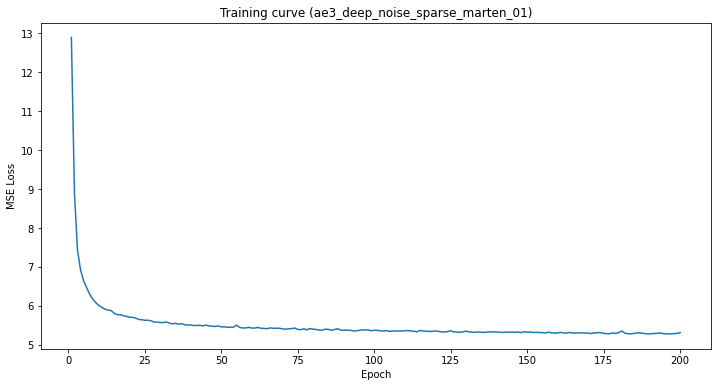

In [119]:
its, losses = get_log(TRAIN_NAME, display=True)

## Output visualization

In [107]:
model_path = sorted(glob(f"./ae_train_NoBackup/{TRAIN_NAME}/model_*.pth"))[-1]
model = Autoencoder()
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "encoder.19.weight", "encoder.19.bias", "decoder.1.weight", "decoder.1.bias". 
	Unexpected key(s) in state_dict: "encoder.20.weight", "encoder.20.bias", "decoder.0.weight", "decoder.0.bias". 
	size mismatch for encoder.1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 3, 7, 7]).
	size mismatch for encoder.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([64, 64, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 32, 5, 5]).
	size mismatch for encoder.13.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for encoder.13.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.16.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for encoder.16.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([64, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 128, 4, 4]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([64, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for decoder.16.weight: copying a param with shape torch.Size([64, 64, 6, 6]) from checkpoint, the shape in current model is torch.Size([64, 32, 6, 6]).
	size mismatch for decoder.16.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.19.weight: copying a param with shape torch.Size([64, 64, 8, 8]) from checkpoint, the shape in current model is torch.Size([32, 16, 8, 8]).
	size mismatch for decoder.19.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.22.weight: copying a param with shape torch.Size([3, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 16, 3, 3]).

In [108]:
only_anomalous = False

def labeler(filename: str) -> int:
    is_normal = (int(filename[-9:-4]) in LABELS[session.name]["normal"])
    return 0 if is_normal else 1

def is_labeled(filename: str) -> bool:
    img_nr = int(filename[-9:-4])
    return (img_nr <= LABELS[session.name]["max"]) and (img_nr not in LABELS[session.name]["not_annotated"]) and (not only_anomalous or img_nr in LABELS[session.name]["anomalous"])

test_dl = create_dataloader(session.get_motion_folder(), shuffle=False, labeler=labeler, filter=is_labeled, skip_transforms=True)

3105 files found


In [109]:
features, labels = next(iter(test_dl))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
input_imgs = model_output_to_image(features).detach()
output_imgs = model_output_to_image(model(features)).detach()

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


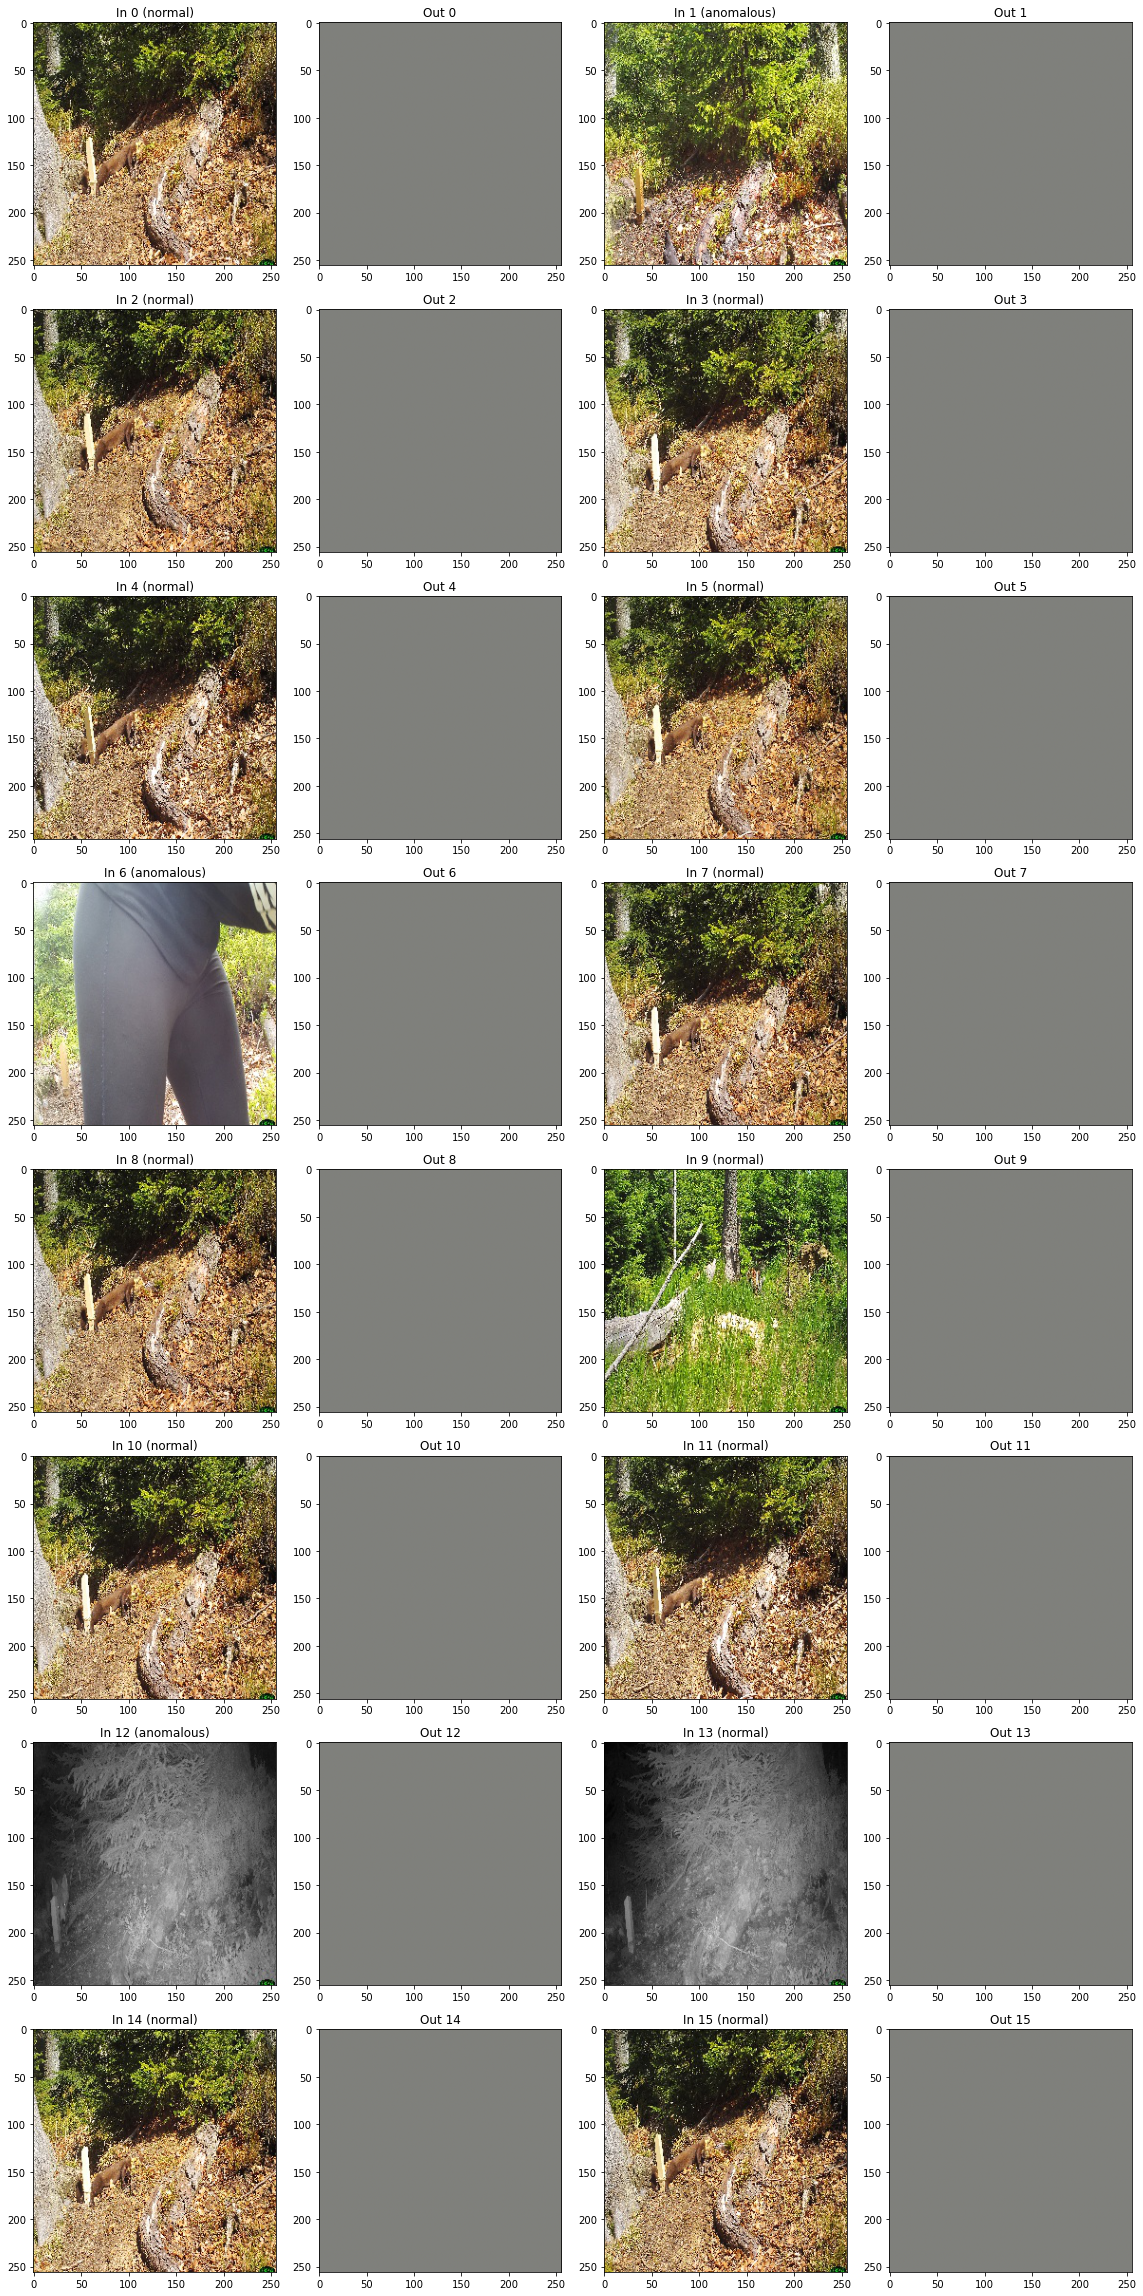

In [110]:
dimgs = []
dlbls = []
only_normals = False
for i in range(32 if only_normals else 16):
    if only_normals and labels[i] == 1:
        continue
    lbl = "anomalous" if labels[i] == 1 else "normal"
    dimgs += [np.einsum("ijk->jki", input_imgs[i]), np.einsum("ijk->jki", output_imgs[i])]
    dlbls += [f"In {i} ({lbl})", f"Out {i}"]
display_images(dimgs, dlbls, size=(4, 4), row_size=4)

In [120]:
lapse_losses, lapse_encodings, lapse_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_lapse.pickle")
motion_losses, motion_encodings, motion_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_motion.pickle")

In [121]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(lapse_encodings)

In [122]:
preds = kde.score_samples(motion_encodings)
y_anom = preds[motion_labels == 1]
y_norm = preds[motion_labels == 0]

In [123]:
pd.Series(y_norm).describe()

count      2373.000000
mean     -34991.740087
std       88811.494949
min     -751982.454578
25%      -13935.661978
50%         316.554855
75%         317.400876
max         319.128383
dtype: float64

In [124]:
pd.Series(y_anom).describe()

count    7.320000e+02
mean    -1.434957e+05
std      2.924113e+05
min     -2.064046e+06
25%     -1.546134e+05
50%     -1.401828e+03
75%      3.170855e+02
max      3.190445e+02
dtype: float64

In [125]:
mode = "kde"

if mode == "kde":
    y_anom = preds[motion_labels == 1]
    y_norm = preds[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss":
    y_anom = motion_losses[motion_labels == 1]
    y_norm = motion_losses[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode in ["kde,loss", "loss,kde"]:
    mode = "kde,loss"
    # generate training data for one-class SVM
    lapse_preds = kde.score_samples(lapse_encodings)
    X_train = np.array([[x1, x2] for x1, x2 in zip(lapse_preds, lapse_losses)])
    X_test = np.array([[x1, x2] for x1, x2 in zip(preds, motion_losses)])
    # train one-class SVM
    clf = OneClassSVM().fit(X_train)
    X = clf.decision_function(X_test).reshape((-1, 1)) # values for thresholding
    y = np.where(motion_labels == 1, 1, -1)
else:
    raise ValueError("unknown mode")


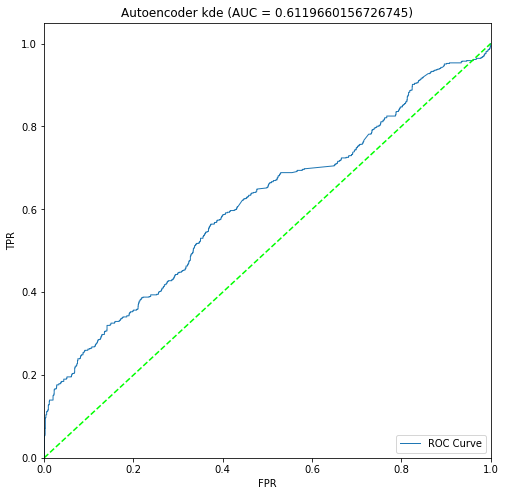

0.9 percentile : TPR = 0.9003, FPR = 0.8247 <-> TNR = 0.1753 @ thresh -317.811294525376
0.95 percentile : TPR = 0.9508, FPR = 0.8963 <-> TNR = 0.1037 @ thresh -318.0677048990311
0.98 percentile : TPR = 0.9809, FPR = 0.9899 <-> TNR = 0.0101 @ thresh -318.48192462996764
0.99 percentile : TPR = 0.9918, FPR = 0.9987 <-> TNR = 0.0013 @ thresh -318.769836152885


In [126]:
fpr, tpr, thresholds, auc_score = plot_roc_curve(y, -X[:,0], f"Autoencoder {mode}", savefile=f"plots/approach4/roc_curves/{session.name}_{mode}")
get_percentiles(fpr, tpr, thresholds)

## AUC Scores

### Beaver_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.5549 |
| KDE | 0.9209 |
| KDE + Loss | 0.9209 |

### Marten_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.8499 |
| KDE | 1.0 |
| KDE + Loss | 1.0 |